# Model training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('./feedback-prize-effectiveness/train.csv')

In [3]:
seed = 33
batch_size = 16
MAX_LEN = 256

In [4]:
from sklearn.model_selection import train_test_split

def data_split(df_train, n_samples, test_size, val_size):
    if n_samples != 0:
        df_train = df_train.sample(n=n_samples, random_state = seed)
    
    
    # Label encoding
    new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}
    df_train = df_train.replace(new_label)
    df_train = df_train.rename(columns = {"discourse_effectiveness": "label"})

    X = df_train['input']
    y = df_train['label']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = seed)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = val_size, random_state = seed)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
import tensorflow as tf
from transformers import TFBertModel
import transformers

In [6]:
df_train

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate
...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking on...,Claim,Adequate
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions ...,Claim,Adequate
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons ...,Position,Adequate
36763,cc184624ca8e,FFA381E58FC6,someone can use everything that many people sa...,Evidence,Ineffective


In [7]:
#prepara los datos para que los pueda procesar BERT
#en tokenizer cada dato solo tiene el largo de 256 y se le indica que ponga un token especial por cada modelo
def bert_encode(texts, tokenizer, max_len=MAX_LEN):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids']) #id del token
        token_type_ids.append(token['token_type_ids']) # lista de tipos de token para cada modelo
        attention_mask.append(token['attention_mask']) #indices que dicen que modelo tiene que atender que token
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
tokenizer.save_pretrained('.')

('.\\tokenizer_config.json',
 '.\\special_tokens_map.json',
 '.\\vocab.txt',
 '.\\added_tokens.json')

In [9]:
#token que indica la separacion de 2 oraciones por 1 input
sep = tokenizer.sep_token
sep

'[SEP]'

In [10]:
df_train['input'] = sep +df_train.discourse_text
df_train['input']

0        [SEP]Hi, i'm Isaac, i'm going to be writing ab...
1        [SEP]On my perspective, I think that the face ...
2        [SEP]I think that the face is a natural landfo...
3        [SEP]If life was on Mars, we would know by now...
4        [SEP]People thought that the face was formed b...
                               ...                        
36760    [SEP]For many people they don't like only aski...
36761    [SEP]also people have different views and opin...
36762    [SEP]Advice is something that can impact a per...
36763    [SEP]someone can use everything that many peop...
36764    [SEP]In conclusion asking for an opinion can b...
Name: input, Length: 36765, dtype: object

In [11]:
n_samples = 0 #no es 0 es todo el dataset
test_size = 0.10
val_size = 0.10

X_train, y_train, X_val, y_val, X_test, y_test = data_split(df_train, n_samples=n_samples, test_size = test_size, val_size = val_size)

In [12]:
X_train

21095    [SEP]If both are possible options, a tradition...
2012     [SEP]Throughtout the article, "The Challenge o...
28317    [SEP]Online learning would allow students to l...
35861    [SEP]With each person one asks for advice, the...
6502     [SEP]The previous quote is stating that scient...
                               ...                        
3790     [SEP]I'm just not sure that it is a good idea ...
25952    [SEP]when the air is polluted, and more people...
26013                 [SEP]we should do Electoral College 
9533     [SEP]Extracurricular activities should be requ...
11812    [SEP]If a summer project was student based, a ...
Name: input, Length: 29779, dtype: object

In [13]:
y_train

21095    2
2012     2
28317    2
35861    2
6502     0
        ..
3790     1
25952    2
26013    1
9533     1
11812    2
Name: label, Length: 29779, dtype: int64

In [14]:
X_train = bert_encode(X_train.astype(str), tokenizer)
X_val = bert_encode(X_val.astype(str), tokenizer)
X_test = bert_encode(X_test.astype(str), tokenizer)

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

In [15]:
y_train

array([2, 2, 2, ..., 1, 1, 2], dtype=int64)

In [16]:
print(f"y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

y_train: (29779,), y_val: (3309,), y_test: (3677,)


In [17]:
AUTO = tf.data.experimental.AUTOTUNE #busca un balance automatico para la load del CPU

#creamos los datasets
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))#crea el dataset de las listas
    .repeat()#no repita el dataset
    .shuffle(1234)#como revuelve el dataset
    .batch(batch_size)#de que tamano
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test, y_test))
    .batch(batch_size)
    .cache()
    .prefetch(AUTO)
)

In [18]:
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

lr = 0.00001

input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")#instancia de tensor
token_type_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name="token_type_ids")
attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

bert_model = (TFBertModel.from_pretrained('bert-base-cased'))
sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
sequence_output

<KerasTensor: shape=(None, 256, 768) dtype=float32 (created by layer 'tf_bert_model')>

In [20]:
lr = 0.00001

clf_output = sequence_output[:, 0, :]#cambiamos la shape del output
clf_output = Dropout(0.3)(clf_output)#asignamos dropout
clf_output = Dense(16, activation='softmax')(clf_output)#capa de neuronas
out = Dense(3, activation='softmax')(clf_output)#capa de salida
    
model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)#agrupamos las capas
model.compile(Adam(lr=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])#compilamos el modelo

c:\Users\Oscar\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
epochs = 15

history = model.fit(
    train_dataset,
    steps_per_epoch=200,
    validation_data=valid_dataset,
    epochs=epochs
)

Epoch 1/15
200/200 [==============================] - 4107s 21s/step - loss: 0.9780 - accuracy: 0.5909 - val_loss: 0.9474 - val_accuracy: 0.6259
Epoch 2/15
200/200 [==============================] - 1801s 9s/step - loss: 0.9333 - accuracy: 0.6278 - val_loss: 0.9336 - val_accuracy: 0.6380
Epoch 3/15
200/200 [==============================] - 1799s 9s/step - loss: 0.9273 - accuracy: 0.6469 - val_loss: 0.9238 - val_accuracy: 0.6510
Epoch 4/15
200/200 [==============================] - 1799s 9s/step - loss: 0.9210 - accuracy: 0.6469 - val_loss: 0.9214 - val_accuracy: 0.6383
Epoch 5/15
200/200 [==============================] - 1794s 9s/step - loss: 0.9150 - accuracy: 0.6559 - val_loss: 0.9183 - val_accuracy: 0.6497
Epoch 6/15
200/200 [==============================] - 1797s 9s/step - loss: 0.9179 - accuracy: 0.6406 - val_loss: 0.9271 - val_accuracy: 0.6189
Epoch 7/15
200/200 [==============================] - 1798s 9s/step - loss: 0.9156 - accuracy: 0.6416 - val_loss: 0.9154 - val_accuracy

In [22]:
model.evaluate(test_dataset)

230/230 [==============================] - 529s 2s/step - loss: 0.8986 - accuracy: 0.6647


[0.8986072540283203, 0.664672315120697]

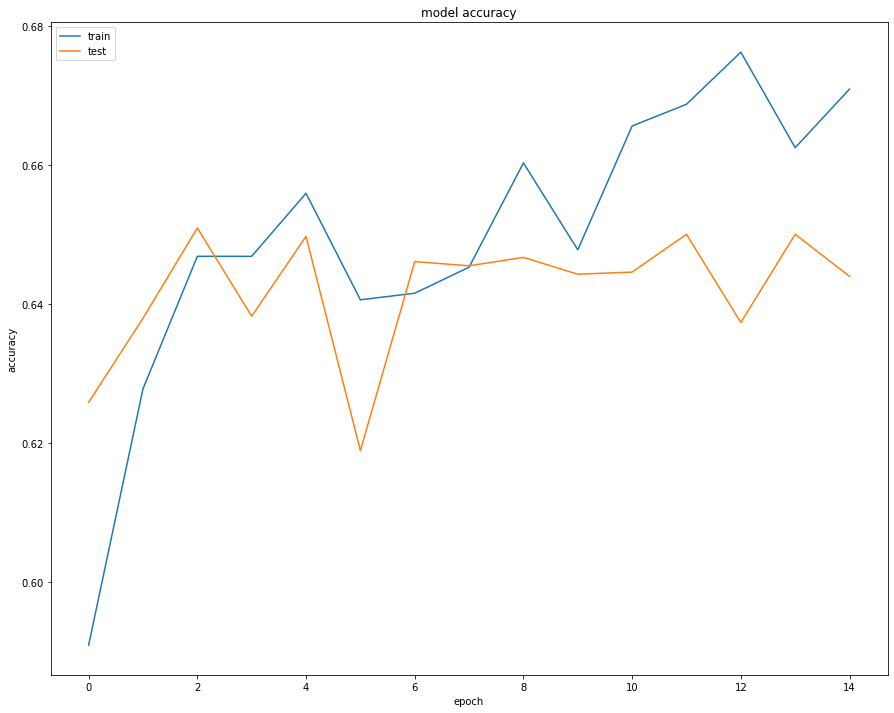

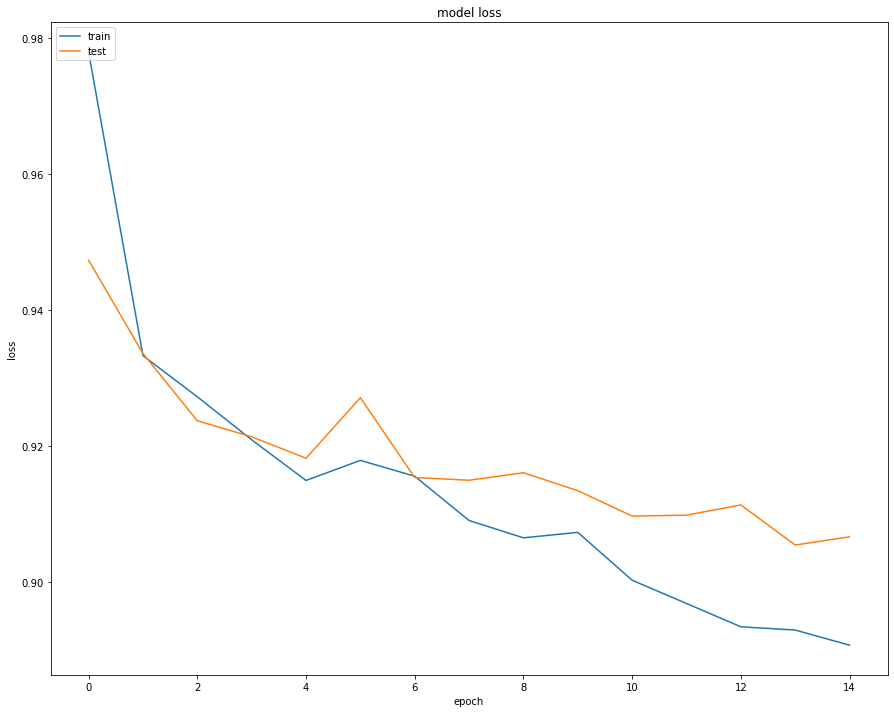

In [23]:
figsize = (15, 12)

plt.figure(figsize=figsize)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=figsize)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
df_test = pd.read_csv('./feedback-prize-effectiveness/test.csv')
df_test.head()

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


In [25]:
pd.read_csv('./feedback-prize-effectiveness/sample_submission.csv').head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.20,0.60,0.40
1,5a88900e7dc1,3.00,6.00,1.00
2,9790d835736b,1.00,2.00,3.00
3,75ce6d68b67b,0.33,0.34,0.33
4,93578d946723,0.01,0.24,0.47


In [26]:
df_test['input'] = df_test.discourse_type + sep + df_test.discourse_text
test_text = bert_encode(df_test.input.astype(str), tokenizer)

In [27]:
pred = model.predict(test_text, verbose=1)
pred

1/1 [==============================] - 4s 4s/step


array([[0.22723724, 0.35880533, 0.41395742],
       [0.23421316, 0.5238702 , 0.24191663],
       [0.23419538, 0.52406424, 0.24174035],
       [0.23421949, 0.5240584 , 0.24172202],
       [0.23430978, 0.5240329 , 0.24165729],
       [0.22708493, 0.35791674, 0.41499835],
       [0.22708498, 0.35791653, 0.41499847],
       [0.23422714, 0.52365327, 0.24211961],
       [0.23345718, 0.41167215, 0.35487068],
       [0.23551625, 0.5022438 , 0.26223996]], dtype=float32)

In [28]:
df_test['Ineffective'] = pred[:,0]
df_test['Adequate'] = pred[:,1]
df_test['Effective'] = pred[:,2]
df_test.drop(['essay_id','discourse_text','discourse_type', 'input'], axis=1, inplace=True)

In [29]:
df_test.head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.227237,0.358805,0.413957
1,5a88900e7dc1,0.234213,0.523870,0.241917
2,9790d835736b,0.234195,0.524064,0.241740
3,75ce6d68b67b,0.234219,0.524058,0.241722
4,93578d946723,0.234310,0.524033,0.241657


In [30]:
df_test.to_csv("submission.csv", index=False)